In [33]:
import u6
from time import sleep
from datetime import datetime

import numpy as np

import matplotlib.pyplot as plt

%pylab inline --no-import-all 
import scipy as sp

Populating the interactive namespace from numpy and matplotlib


In [34]:
# MAX_REQUESTS is the number of packets to be read.
MAX_REQUESTS = 32
SCAN_FREQ=32768
# the number of samples will be MAX_REQUESTS times 48 (packets per request) times 25 (samples per packet).
d = u6.U6()

# Set up U6
d.configU6()

# For applying the proper calibration to readings.
d.getCalibrationData()

# Set the FIO0 to Analog
d.configIO()

print "configuring U6 stream"
d.streamConfig( NumChannels = 1,SamplesPerPacket=16, ResolutionIndex = 0, ScanFrequency = SCAN_FREQ )


configuring U6 stream


In [35]:
def getData():
    data=np.array([],dtype=float)
    try:
       # print "start stream",
        d.streamStart()
        start = datetime.now()
        #print start
        
        missed = 0
        dataCount = 0
        packetCount = 0
    
        for r in d.streamData():
            if r is not None:
                # Our stop condition
                if dataCount >= MAX_REQUESTS:
                    break
                
                if r['errors'] != 0:
                    print "Error: %s ; " % r['errors'], datetime.now()
    
                if r['numPackets'] != d.packetsPerRequest:
                    print "----- UNDERFLOW : %s : " % r['numPackets'], datetime.now()
    
                if r['missed'] != 0:
                    missed += r['missed']
                    print "+++ Missed ", r['missed']
               
                data=np.append(data,r['AIN0'])
               
                dataCount += 1
                packetCount += r['numPackets']
            else:
                # Got no data back from our read.
                # This only happens if your stream isn't faster than the 
                # the USB read timeout, ~1 sec.
                print "No data", datetime.now()
    except:
        print "".join(i for i in traceback.format_exc())
    finally:
        stop = datetime.now()
        d.streamStop()
       
    return(data)

In [19]:
# setDAC takes a voltage value, converts to 16 bit value, then puts
# outputs voltage to channel 0
def setDAC(Volts):
    bVolts=d.voltageToDACBits(Volts,dacNumber=0,is16Bits=True)
    d.getFeedback(u6.DAC16( 0,  bVolts))
    return

In [6]:
# cycleData creates a table of voltages to output to DAC,
# wait for voltage to settle, and store rms value found at input
# variable rms stores the spectrum and is what is returned

def cycleData(lowV, HighV, numV):
    volts=np.linspace(lowV,HighV,numV)    
    rms=np.array([],dtype=float)
    for i in volts:
        setDAC(i)
        sleep(.2)
        rms=np.append(rms,np.std(getData()))
        
    return (rms)

In [24]:
# getFreq is used to get start and stop frequency of run,
# since we are not driving an oscillator directly, rather we 
# use a freq. gen. that has a VCO setting, so we need to know what
# frequencies are start and stop voltages correspond to
# later we assume this is linear. Of course this depends on the 
# freq. gen. and ought to be tested.
    
def getFreq(y,Fs):
    
    n = len(y) # length of the signal

    k = np.arange(n)

    T = 1.*n/Fs

    #print T
    frq = k/T # two sides frequency range
    frq = frq[range(n/2)] # one side frequency range
   
    Y = sp.fft(y)*10. # fft computing and normalization
   
    fig, axes=plt.subplots()
    axes.plot(y)
    return frq[np.argmax(Y[1:n/2])]

In [25]:
def plotData(freq, power):
    fig, axes = plt.subplots(1,1)
    axes.plot(freq, power, label ='Rs')
    axes.set_xlabel('frequency (Hz)')
    axes.set_ylabel('rms voltage (V)')
    axes.legend()

In [26]:
LowV=0.
HighV=4.
numberData=100


64.0


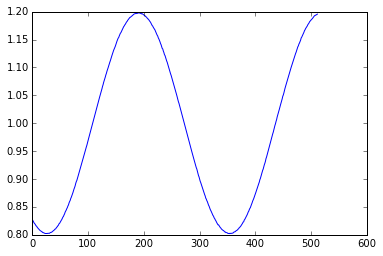

In [31]:
setDAC(LowV)
start_FREQ=getFreq(getData(),SCAN_FREQ)
print(start_FREQ)

64.0

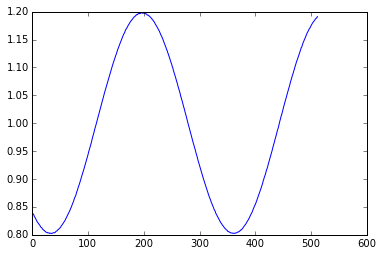

In [30]:
setDAC(HighV)
end_FREQ=getFreq(getData(),SCAN_FREQ)
end_FREQ

1792.0

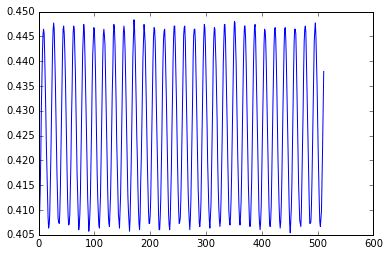

In [13]:
getFreq(getData(),SCAN_FREQ)


In [16]:
#take spectrum
spectrum=cycleData(LowV, HighV, numberData)
setDAC(0)

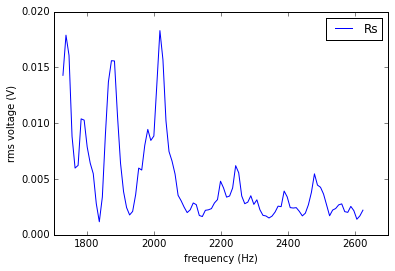

In [17]:
freq=np.linspace(start_FREQ,end_FREQ,numberData)
plotData(freq,spectrum)


In [68]:
data_out=np.column_stack((freq[:,np.newaxis],spectrum[:,np.newaxis]))
np.savetxt('test.out', data_out, delimiter=',')

NameError: name 'freq' is not defined

In [39]:
d.close()

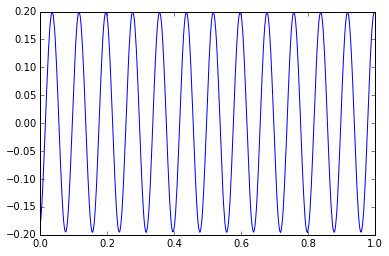

In [38]:
data=getData()
fig, axes = plt.subplots(1,1)
axes.plot(np.linspace(0,1,len(data)), data, label ='Rs')